# Greeks for an Arithmetic-Average Asian Call  
### Pathwise • Likelihood-Ratio • Finite-Difference

Under the umbrella project **“Pricing Exotic Options using Stochastic
Calculus, PDEs, and Monte-Carlo Simulations,”** this notebook highlights
three main Monte-Carlo techniques for Greeks:

| Greek | Estimators here | Key idea |
|-------|-----------------|----------|
| Δ     | Pathwise (PW) — derivative of payoff<br>Likelihood-Ratio (LR) — derivative of log-density<br>Finite-Difference (FD) — bump-and-revalue | PW lowest variance; LR calculus-based; FD benchmark |
| Γ     | Finite-Difference | PW not available; LR very noisy so omitted |
| ν     | Finite-Difference | (a “Vega bump”) |

We print 95 % confidence intervals (CI) and plot convergence variance.

## Parameters Setup

- `S0`:    100  Initial stock price  
- `K`:     100  Strike price  
- `r`:     5%   Risk-free interest rate  
- `T`:     1    Time to maturity (in years)  
- `sigma`: 20%  Volatility of the underlying  
- `M`:     252  Number of time steps  
- `N`:         Simulated paths

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

S0, K, r, T, sigma, M = 100, 100, 0.05, 1.0, 0.20, 252
np.random.seed(42)

In [2]:
# GBM path simulator (returns paths & Z)
def simulate_paths(S0, r, sigma, T, M, N, antithetic=False):
    """Returns (paths, Z).  Paths exclude the initial S₀ column."""
    if antithetic and N % 2:  # force even
        N += 1
    dt = T / M
    rows = N // 2 if antithetic else N
    Z = np.random.randn(rows, M)
    if antithetic:
        Z = np.vstack([Z, -Z])
    log_inc = (r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z
    log_paths = np.cumsum(log_inc, axis=1)
    return S0 * np.exp(log_paths), Z

In [3]:
# Arithmetic-average payoff
def asian_payoff(paths, K):
    A = paths.mean(axis=1)
    return np.maximum(A - K, 0)

In [4]:
# Plain MC price (for FD bumps)
def asian_mc_price(S0, K, r, T, sigma, M, N):
    paths, _ = simulate_paths(S0, r, sigma, T, M, N)
    payoff = asian_payoff(paths, K)
    disc = np.exp(-r * T) * payoff
    mean = disc.mean()
    se = disc.std(ddof=1) / np.sqrt(N)
    return mean, 1.96 * se  # half-width CI

In [5]:
# Finite-Difference Greeks (vectorised, common RN)
def asian_greeks_fd(S0, K, r, T, sigma, M, N, h=0.5):
    """FD Δ, Γ, ν  + 95 % CI half-widths, uses common random numbers."""
    Z = np.random.randn(N, M)

    def price(S0_, sigma_):
        dt = T / M
        log = np.cumsum((r - 0.5 * sigma_**2) * dt + sigma_ * np.sqrt(dt) * Z, axis=1)
        pay = asian_payoff(S0_ * np.exp(log), K)
        return np.exp(-r * T) * pay

    p = price(S0, sigma)
    pU = price(S0 + h, sigma)
    pD = price(S0 - h, sigma)
    pV = price(S0, sigma + h)

    Δ = (pU - pD) / (2 * h)
    Γ = (pU - 2 * p + pD) / h**2
    ν = (pV - p) / h

    def mean_ci(a):
        m, se = a.mean(), a.std(ddof=1) / np.sqrt(N)
        return m, 1.96 * se

    return mean_ci(Δ), mean_ci(Γ), mean_ci(ν)

In [6]:
# Pathwise Delta (lowest variance)
def asian_delta_pw(S0, K, r, T, sigma, M, N):
    paths, _ = simulate_paths(S0, r, sigma, T, M, N)
    A = paths.mean(axis=1)
    ind = (A > K).astype(float)
    weights = np.arange(1, M + 1) / M / S0
    dA_dS0 = weights.sum()
    grad = np.exp(-r * T) * ind * dA_dS0
    mean = grad.mean()
    se = grad.std(ddof=1) / np.sqrt(N)
    return mean, 1.96 * se

In [7]:
# Likelihood-Ratio Delta (calculus-based)
def asian_delta_lr(S0, K, r, T, sigma, M, N):
    paths, Z = simulate_paths(S0, r, sigma, T, M, N)
    payoff = asian_payoff(paths, K)
    lr_weight = Z.sum(axis=1) / (sigma * np.sqrt(T))  # d log p / dS0 ratio
    grad = np.exp(-r * T) * payoff * lr_weight / S0
    mean = grad.mean()
    se = grad.std(ddof=1) / np.sqrt(N)
    return mean, 1.96 * se

In [8]:
# Numerical Greeks at baseline parameters
N0 = 40_000
# FD
(Δ_fd, ciΔ_fd), (Γ_fd, ciΓ_fd), (ν_fd, ciν_fd) = asian_greeks_fd(
    S0, K, r, T, sigma, M, N0
)
# PW & LR
Δ_pw, ciΔ_pw = asian_delta_pw(S0, K, r, T, sigma, M, N0)
Δ_lr, ciΔ_lr = asian_delta_lr(S0, K, r, T, sigma, M, N0)

print(f"Delta  (PW) = {Δ_pw:.4f} ± {ciΔ_pw:.4f}")
print(f"Delta  (LR) = {Δ_lr:.4f} ± {ciΔ_lr:.4f}")
print(f"Delta  (FD) = {Δ_fd:.4f} ± {ciΔ_fd:.4f}")
print(f"Gamma  (FD) = {Γ_fd:.4f} ± {ciΓ_fd:.4f}")
print(f"Vega   (FD) = {ν_fd:.4f} ± {ciν_fd:.4f}")

Delta  (PW) = 0.6739 ± 0.0059
Delta  (LR) = 4.7554 ± 0.1116
Delta  (FD) = 0.5904 ± 0.0051
Gamma  (FD) = 0.0331 ± 0.0020
Vega   (FD) = 21.5863 ± 0.4813


## Convergence of Δ — PW vs LR vs FD

In [9]:
# Build convergence arrays
N_grid = np.linspace(2_000, 60_000, 18, dtype=int)
pw_m, pw_ci = [], []
lr_m, lr_ci = [], []
fd_m, fd_ci = [], []

for N in N_grid:
    dpw, cipw = asian_delta_pw(S0, K, r, T, sigma, M, N)
    dlr, cilr = asian_delta_lr(S0, K, r, T, sigma, M, N)
    (dfd, cidfd), _, _ = asian_greeks_fd(S0, K, r, T, sigma, M, N)
    pw_m.append(dpw)
    pw_ci.append(cipw)
    lr_m.append(dlr)
    lr_ci.append(cilr)
    fd_m.append(dfd)
    fd_ci.append(cidfd)

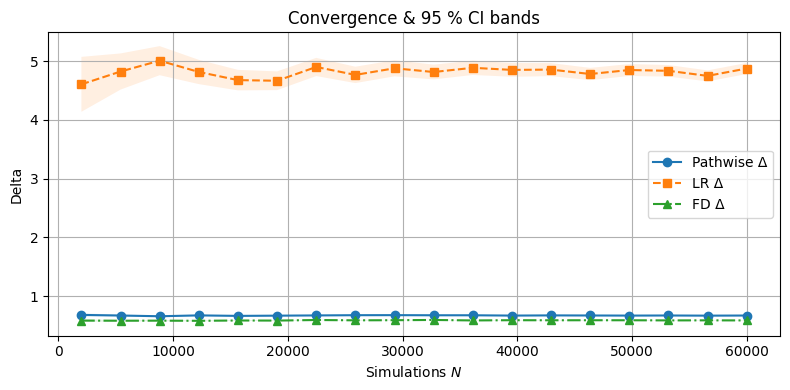

In [10]:
# Plot Δ convergence
plt.figure(figsize=(8, 4))
for m, ci, style, lab in [
    (pw_m, pw_ci, "o-", "Pathwise Δ"),
    (lr_m, lr_ci, "s--", "LR Δ"),
    (fd_m, fd_ci, "^-.", "FD Δ"),
]:
    m, ci = np.array(m), np.array(ci)
    plt.plot(N_grid, m, style, label=lab)
    plt.fill_between(N_grid, m - ci, m + ci, alpha=0.12)

plt.xlabel("Simulations $N$")
plt.ylabel("Delta")
plt.title("Convergence & 95 % CI bands")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

## Γ vs \(S_0\)  — Finite-Difference

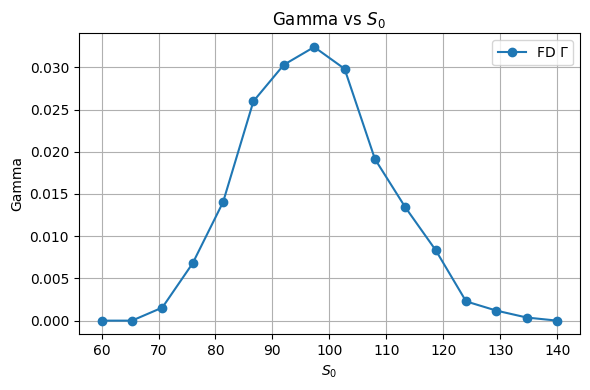

In [11]:
#  Plot Γ curve
S_range = np.linspace(60, 140, 16)
gamma_est = [
    asian_greeks_fd(s, K, r, T, sigma, M, 12_000)[1][0]  # take FD Γ mean
    for s in S_range
]

plt.figure(figsize=(6, 4))
plt.plot(S_range, gamma_est, "o-", label="FD Γ")
plt.xlabel("$S_0$")
plt.ylabel("Gamma")
plt.title("Gamma vs $S_0$")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

## ν (Vega) vs σ   Finite-Difference

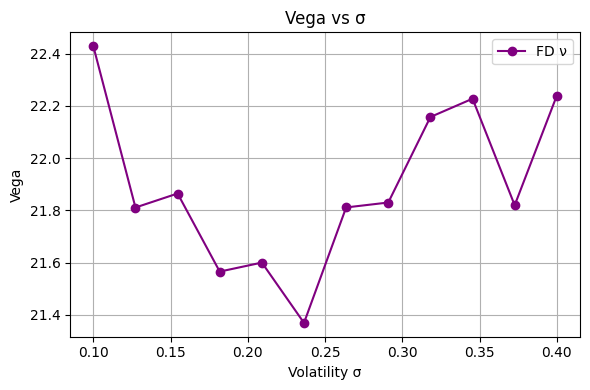

In [12]:
# Plot ν curve
sigma_range = np.linspace(0.10, 0.40, 12)
vega_est = [
    asian_greeks_fd(S0, K, r, T, sig, M, 12_000)[2][0]  # FD ν mean
    for sig in sigma_range
]

plt.figure(figsize=(6, 4))
plt.plot(sigma_range, vega_est, "o-", color="purple", label="FD ν")
plt.xlabel("Volatility σ")
plt.ylabel("Vega")
plt.title("Vega vs σ")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

### Key take-aways  
* **Pathwise Delta** delivers the tightest CI and should be preferred for hedging.  
* **Likelihood-Ratio Delta** is unbiased but higher-variance; useful for non-differentiable payoffs.  
* **Finite-Difference** provides Δ, Γ, ν but inherits price noise and requires multiple valuations.   